### Get the Data
We'll be using a dataset from the [UCI datasets](https://archive.ics.uci.edu/dataset/228/sms+spam+collection)! This dataset is already located in the folder for this section.

The file we are using contains a collection of more than 5 thousand SMS phone messages. You can check out the **readme** file for more info.

Let's go ahead and use rstrip() plus a list comprehension to get a list of all the lines of text messages:

In [4]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [8]:
# Open the file and read all lines

file = open('SMSSpamCollection', 'r')
#strip for remove unwanted spaces
messages = [line.strip() for line in file]

print(len(messages))
print(messages[0])

5574
ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


In [10]:
#A collection of texts is also sometimes called "corpus". Let's print the first ten messages and number them using enumerate:

for mess_no,message in enumerate(messages[:10]):
    print(mess_no,message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim cod

In [12]:
#just see the message like it shows tab seprated, \tab indicates the message
messages[0]

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

Due to the spacing we can tell that this is a TSV ("tab separated values") file, where the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself.

Using these labeled ham and spam examples, we'll **train a machine learning model to learn to discriminate between ham/spam automatically**.

In [13]:
#create dataframe and label seprated by tab
import pandas as pd

messages= pd.read_csv('SMSSpamCollection' 
                      ,sep='\t'
                      ,names=['label','message'])

messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis
Let's check out some of the stats with some plots and the built-in methods in pandas!

In [14]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [15]:
#use groupby to use describe by label, this way we can begin to think about the features that separate ham and spam!
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [16]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Data Visualization

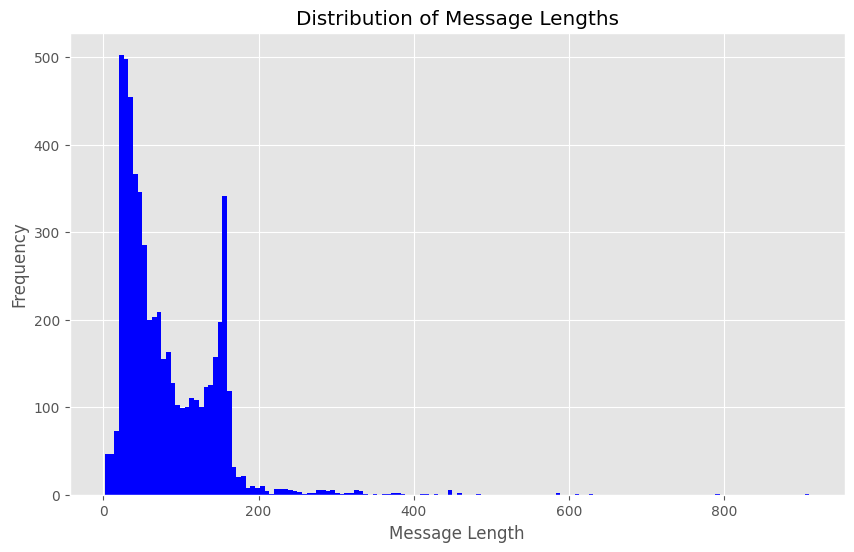

In [36]:
import matplotlib.pyplot as plt


plt.style.use('ggplot')  # Use a grid style for better readability

# Plot the histogram
messages['length'].plot.hist(bins=150, figsize=(10, 6), color='blue')

# Add labels and title
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.title('Distribution of Message Lengths')
plt.show()


In [28]:
messages['length'].describe()

#to find the max length of the message

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [29]:
messages[messages['length'] == 910]['message'].iloc[0]

#to find that max length msg

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

let's focus back on the idea of trying to see if message length is a distinguishing feature between ham and spam:

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

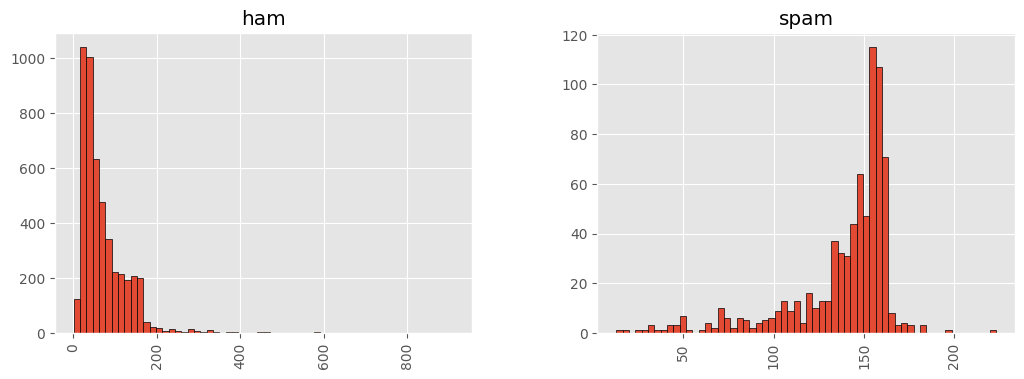

In [44]:
messages.hist(column='length',by='label',bins=60,figsize=(12,4),grid=True,edgecolor='black')

### Text Preprocessing (convert to vectorized format)

Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the bag-of-words approach, where each unique word in a text will be represented by one number.

In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

Let's create a function that will process the string in the message column, then we can just use apply() in pandas do process all the text in the DataFrame.

First removing punctuation. We can just take advantage of Python's built-in string library to get a quick list of all the possible punctuation:

In [67]:
import string
#to check string punctuation and removes that.

mess = 'Sample message! Notice: it has punctuation.'
nopunc = []

# Loop through each character in the message
for c in mess:
    if c not in string.punctuation:
        nopunc.append(c)

# Print the list of characters
print(nopunc)


['S', 'a', 'm', 'p', 'l', 'e', ' ', 'm', 'e', 's', 's', 'a', 'g', 'e', ' ', 'N', 'o', 't', 'i', 'c', 'e', ' ', 'i', 't', ' ', 'h', 'a', 's', ' ', 'p', 'u', 'n', 'c', 't', 'u', 'a', 't', 'i', 'o', 'n']


In [69]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

"""They don’t add significant meaning to the text. Removing these words is a common preprocessing step in many NLP tasks."""

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

'They don’t add significant meaning to the text. Removing these words is a common preprocessing step in many NLP tasks.'

In [70]:
nopunc= ''.join(nopunc)
nopunc

'Sample message Notice it has punctuation'

In [71]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [72]:
 # Assuming you have already removed punctuation
stop_words = stopwords.words('english')

clean_mess = []

# Loop through each word in the message
for word in nopunc.split():
    if word.lower() not in stop_words:  # If the word is not a stopword
        clean_mess.append(word)

print(clean_mess)

['Sample', 'message', 'Notice', 'punctuation']


Now let's put both of these together in a function to apply it to our DataFrame later on:

In [73]:
import string
from nltk.corpus import stopwords

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Removes all punctuation
    2. Removes all stopwords
    3. Returns a list of the cleaned text
    """
    # Remove punctuation using a normal for loop
    nopunc = ""
    for char in mess:
        if char not in string.punctuation:
            nopunc += char
    
    # Remove stopwords using a normal for loop
    stop_words = set(stopwords.words('english'))  # Using a set for faster lookup
    cleaned_text = []
    for word in nopunc.split():
        if word.lower() not in stop_words:
            cleaned_text.append(word)
    
    return cleaned_text


In [74]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

Let's see an example output on on column:

In [75]:
# Check to make sure its working
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [76]:
# Show original dataframe
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Continuing Normalization
There are a lot of ways to continue normalizing this text. Such as Stemming or distinguishing by part of speech.

NLTK has lots of built-in tools and great documentation on a lot of these methods. Sometimes they don't work well for text-messages due to the way a lot of people tend to use abbreviations or shorthand, For example:

'Nah dawg, IDK! Wut time u headin to da club?'
versus

'No dog, I don't know! What time are you heading to the club?'
Some text normalization methods will have trouble with this type of shorthand and so I'll leave you to explore those more advanced methods through the NLTK book online.

For now we will just focus on using what we have to convert our list of words to an actual vector that SciKit-Learn can use.

### Vectorization
Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

Count how many times does a word occur in each message (Known as term frequency)

Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus. We will first use SciKit Learn's CountVectorizer. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message.

In [77]:
from sklearn.feature_extraction.text import CountVectorizer

In [78]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


Let's take one text message and get its bag-of-words counts as a vector, putting to use our new bow_transformer:

In [79]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


Now let's see its vector representation:

In [80]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 7 stored elements and shape (1, 11425)>
  Coords	Values
  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


In [81]:
print(bow_transformer.get_feature_names_out()[4068])
print(bow_transformer.get_feature_names_out()[9554])

U
say


Now we can use .transform on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [82]:
messages_bow = bow_transformer.transform(messages['message'])

In [83]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [84]:
#no. of non zeros(nnz)

messages_bow.nnz

50548

# sparsity = (1 - ( messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))) 

In [88]:
print(messages_bow.shape[0])
print(messages_bow.shape[1])
print(messages_bow.nnz)

5572
11425
50548


5572 * 11425 = 63660100
50548 / 63660100 = 0.0007940295412668218
1 - 0.0007940295412668218 = 0.9992059704587332

In [93]:
sparsity = (1 - ( messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))
print('sparsity: {}'.format(sparsity))

sparsity: 0.9992059704587332


### TF: 
Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

### IDF: 
Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

See below for a simple example.

### Example:

Consider a document containing 100 words wherein the word cat appears 3 times.

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.

In [94]:
from sklearn.feature_extraction.text import TfidfTransformer

# Step 1: Initialize and fit the TF-IDF Transformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)

# Step 2: Transform a specific Bag-of-Words vector to TF-IDF representation
tfidf4 = tfidf_transformer.transform(bow4)

# Step 3: Print the transformed vector
print(tfidf4)


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7 stored elements and shape (1, 11425)>
  Coords	Values
  (0, 4068)	0.4083258993338407
  (0, 4629)	0.2661980190608719
  (0, 5261)	0.2972995740586873
  (0, 6204)	0.2995379972369742
  (0, 6222)	0.31872168929491496
  (0, 7186)	0.4389365653379858
  (0, 9554)	0.5385626262927565


We'll go ahead and check what is the IDF (inverse document frequency) of the word  "university"?

In [95]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])


8.527076498901426


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [96]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


In [97]:
messages_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 50548 stored elements and shape (5572, 11425)>

There are many ways the data can be preprocessed and vectorized. These steps involve feature engineering and building a "pipeline". I encourage you to check out SciKit Learn's documentation on dealing with text data as well as the expansive collection of available papers and books on the general topic of NLP.

### Training a model

With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a **variety of reasons**, the Naive Bayes classifier algorithm is a good choice.

We'll be using scikit-learn here, choosing the **Naive Bayes classifier** to start with:

In [98]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

Let's try classifying our single random message and checking how we do:

In [99]:
tfidf4

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7 stored elements and shape (1, 11425)>

In [100]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


In [101]:
messages

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160
5568,ham,Will ü b going to esplanade fr home?,36
5569,ham,"Pity, * was in mood for that. So...any other s...",57
5570,ham,The guy did some bitching but I acted like i'd...,125


In [ ]:
Fantastic! We've developed a model that can attempt to predict spam vs ham classification!

### Part 6: Model Evaluation

Now we want to determine how well our model will do overall on the entire dataset. Let's begin by getting all the predictions:

In [102]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


### Train Test Split



In [103]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


### Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's pipeline capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:


### Step-by-Step Explanation

### Pipeline Components:

CountVectorizer(analyzer=text_process):
Converts raw text into a Bag-of-Words representation (token integer counts) using the custom text_process function.

TfidfTransformer():
Converts the Bag-of-Words representation into a Term Frequency-Inverse Document Frequency (TF-IDF) representation, assigning weights to terms based on their importance.

MultinomialNB() (or RandomForestClassifier()):
Trains a machine learning model using the processed TF-IDF features.

Fitting the Model:

pipeline.fit(msg_train, label_train):
Trains the entire pipeline on the training dataset (msg_train and label_train).
The pipeline handles all preprocessing steps and model training internally.

Making Predictions:

predictions = pipeline.predict(msg_test):
Applies the trained pipeline to the test dataset (msg_test) to generate predictions for unseen messages.

In [104]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    #('classifier', RandomForestClassifier()),  # train on TF-IDF vectors w/ Naive Bayes classifier
    ('classifier', MultinomialNB())
])

In [105]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001E79229B6A0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [106]:
predictions = pipeline.predict(msg_test)

### Use the Model

**Predict a Single Message:**

You can use the trained pipeline to classify new messages:

In [107]:
new_message = ["This is an example spam message."]
prediction = pipeline.predict(new_message)
print("Prediction:", prediction)

Prediction: ['ham']
